In [3]:
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
from modules import functions as f
warnings.filterwarnings("ignore")
from scipy.stats import norm

In [4]:
# fix random seed for reproducibility
seed = 26415
np.random.seed(seed)

In [5]:
SETFI = pd.read_csv('SETFI.csv')
SETFI_LOT = SETFI.filter(regex='lot')
SETFI_LOCN = SETFI.filter(regex='locn')
SETFI_RES = SETFI.filter(regex='res')
SETFI_Filtered = pd.concat([SETFI_LOCN, SETFI_RES], axis=1)
SETFI_Filtered = SETFI_Filtered.replace(" ", np.nan)
#sort
SETFI_Filtered = SETFI_Filtered.sort_values(by=['res'], ascending=False)
origin = SETFI_Filtered.copy()

In [6]:
SETFI_Filtered.head(50)

,locn1,locn2,locn3,locn4,locn5,locn6,locn7,locn8,locn9,locn10,...,locn292,locn293,locn294,locn295,locn296,locn297,locn298,locn299,locn300,res
919,10,3,9,4,1,14,1,2,NaN,3,...,4,NaN,1,4,2,5,10,5,NaN,3293.183338
2565,6,1,NaN,2,NaN,NaN,5,NaN,NaN,2,...,5,3,2,3,10,NaN,NaN,4,5,3251.461519
3655,5,5,4,1,4,3,5,5,7,2,...,8,5,4,NaN,3,3,12,5,3,3251.260097
1732,7,1,NaN,4,5,14,1,2,6,NaN,...,5,4,4,NaN,4,1,12,5,5,3247.466431
1393,2,4,8,4,4,NaN,NaN,7,8,4,...,7,1,2,2,10,3,NaN,5,3,3247.333872
3359,7,5,2,5,2,14,5,8,4,2,...,9,5,2,5,9,4,13,4,4,3213.342951
558,10,3,NaN,2,2,3,3,7,8,NaN,...,NaN,1,4,7,9,4,8,2,1,3212.135793
2811,2,4,6,2,5,3,2,3,9,NaN,...,9,2,3,6,NaN,1,5,NaN,5,3208.171168
3967,8,5,9,4,4,NaN,5,NaN,NaN,2,...,1,NaN,2,1,10,1,12,1,1,3207.728170
1307,6,4,NaN,3,2,9,5,3,NaN,2,...,NaN,3,3,7,3,3,8,2,2,3200.783822


In [7]:
#Calculate values for res.
res_mean,res_std,res_max,res_min,res_median = SETFI_RES.mean(axis=0), SETFI_RES.std(axis=0), SETFI_RES.min(axis=0), SETFI_RES.max(axis=0), SETFI_RES.median(axis=0)
print('res_mean: ', res_mean.values[0], '\tres_std: ', res_std.values[0], '\tres_max: ', res_max.values[0], '\tres_min: ', res_min.values[0], '\tres_median: ', res_median.values[0])

res_mean:  2782.9244763804218 	res_std:  125.8480832126734 	res_max:  2177.43775124638 	res_min:  3293.183337577 	res_median:  2783.992359690425


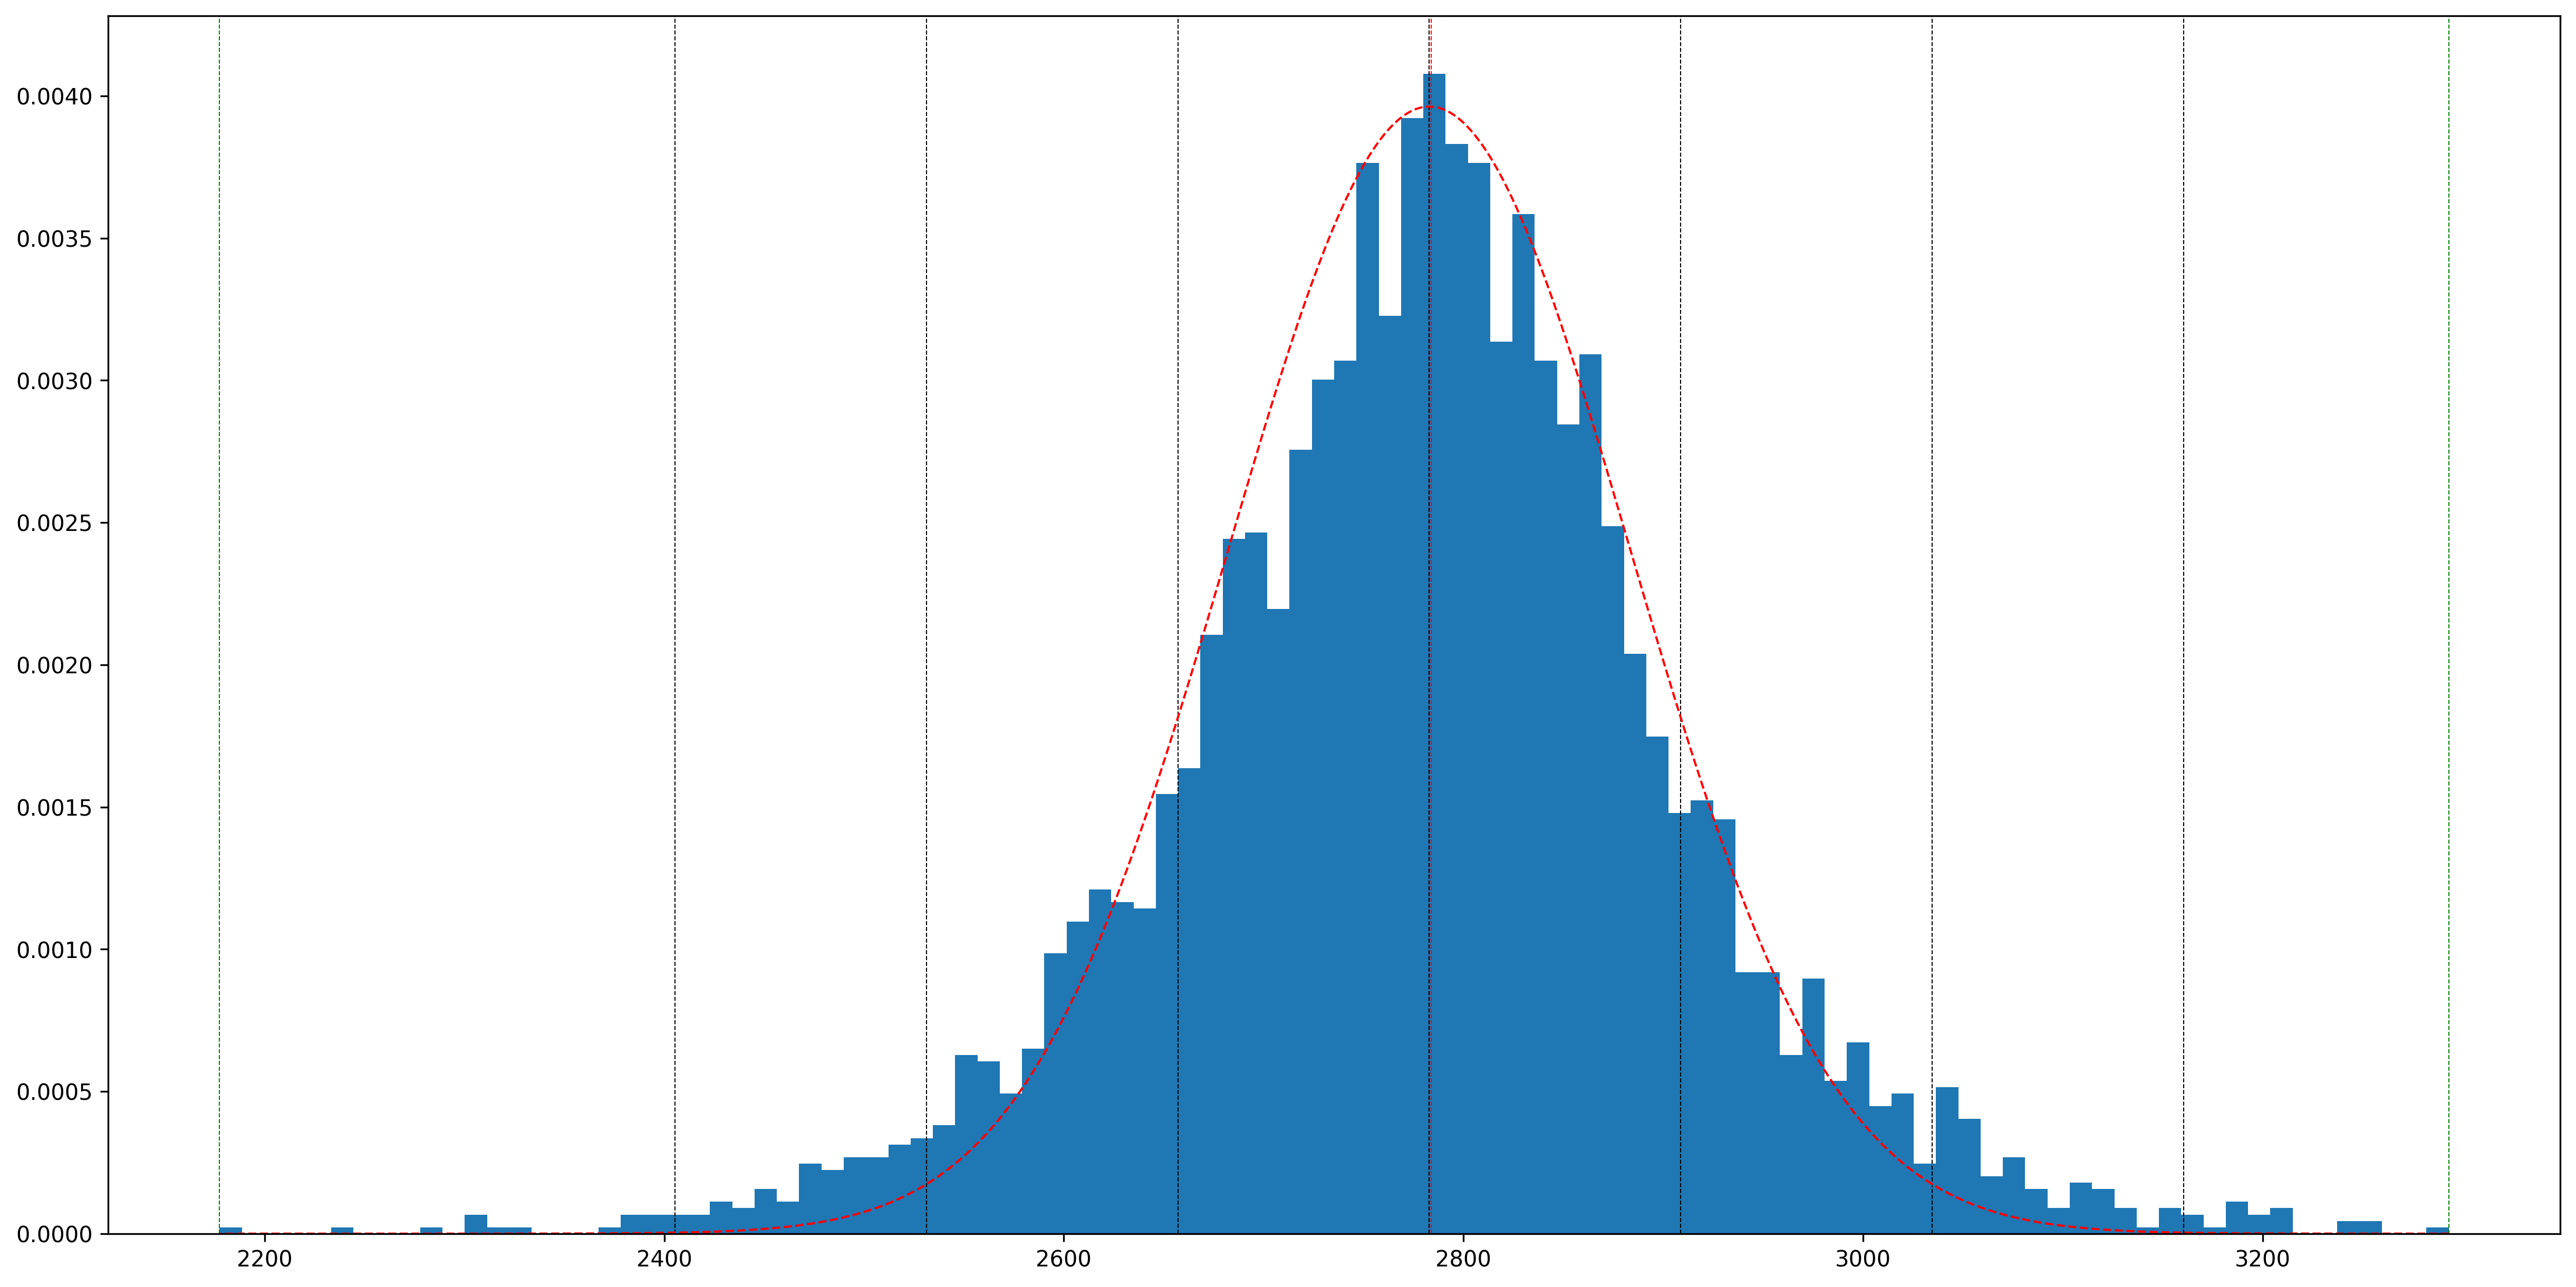

In [8]:
# mean, std에 따른 정규분포 곡선 그리기
x = np.linspace(res_min.values[0], res_max.values[0], 1000)
plt.figure(figsize=(20,10), dpi=300)
plt.hist(SETFI_RES.values, bins=100, density=True)
plt.axvline(res_mean.values[0], color='k', linestyle='dashed', linewidth=0.5)
for i in range(1,4):
    plt.axvline(res_mean.values[0]+i*res_std.values[0], color='k', linestyle='dashed', linewidth=0.5)
    plt.axvline(res_mean.values[0]-i*res_std.values[0], color='k', linestyle='dashed', linewidth=0.5)
    #plt.plot(x, norm.pdf(x, res_mean.values[0], i*res_std.values[0]), color='r', linestyle='dashed', linewidth=1)
plt.axvline(res_median.values[0], color='r', linestyle='dashed', linewidth=0.5)
plt.axvline(res_max.values[0], color='g', linestyle='dashed', linewidth=0.5)
plt.axvline(res_min.values[0], color='g', linestyle='dashed', linewidth=0.5)
plt.plot(x, norm.pdf(x, res_mean.values[0], 0.8*res_std.values[0]), color='r', linestyle='dashed', linewidth=1)
plt.show()

In [9]:
class SETFI_Class:
    def __init__(self, dataframe):
        self.dataframe = pd.read_csv(dataframe)
        self.dataframe_locn = self.dataframe.filter(regex='locn')
        self.dataframe_res = self.dataframe.filter(regex='res')
        self.dataframe = pd.concat([self.dataframe_locn, self.dataframe_res], axis=1)
        self.dataframe = self.dataframe.replace(" ", np.nan)
        self.dataframe = self.dataframe.sort_values(by=['res'], ascending=False)
        
        
        self.stages = list(self.dataframe.filter(regex='locn').values) # stages of SETFI_Filtered
        self.res_mean = self.dataframe.filter(regex='res').mean(axis=0).values[0] # res_mean of SETFI_Filtered
        self.res_std = self.dataframe.filter(regex='res').std(axis=0).values[0] # res_std of SETFI_Filtered
        self.res_max = self.dataframe.filter(regex='res').max(axis=0).values[0] # res_max of SETFI_Filtered
        self.res_min = self.dataframe.filter(regex='res').min(axis=0).values[0] # res_min of SETFI_Filtered
        self.res_median = self.dataframe.filter(regex='res').median(axis=0).values[0]# res_median of SETFI_Filtered
        
    def get_row(self, row_index):
        return self.dataframe.iloc[row_index]
        
    def get_NaN_index(self, row_index):
        row = self.get_row(row_index)
        index_list = []
        for i in range(len(row.isnull().values)):
            if row.isnull().values[i] == True:
                index_list.append(i)
        return index_list
    
    def get_window_dataframe(self, window_size, index, verbose=False):
        start_index = max(0, (index - window_size // 2))
        end_index = min(len(self.dataframe), (index + window_size // 2))
        print('start_index: ', start_index, 'end_index: ', end_index) if verbose else None
        return self.dataframe.iloc[start_index:end_index]
    
    def fill_NaN(self, window_size, row_index, rank = 1, verbose=False):
        #row에 NaN이 있는 index를 가져옴
        NaN_index = self.get_NaN_index(row_index)
        print('NaN_index: ', NaN_index, "Total NaN: ", len(NaN_index)) if verbose else None
        #해당 인덱스를 돌면서 NaN을 채움. extract_df의 해당 인덱스에서 많이 등장하는 값을 가져옴.
        non_zero_count = 0
        extracted_df = self.get_window_dataframe(window_size, row_index, verbose)
        for i in NaN_index:
            value_counts = extracted_df.iloc[:,i].value_counts()
            #rank만큼 자름
            value_counts = value_counts[:rank]
            #print('value_counts: ', len(value_counts)) if verbose else None
            rand_index = np.random.randint(0, len(value_counts))
            #NaN을 채움
            self.dataframe.iloc[row_index, i] = value_counts.index[rand_index]
            print('replace: ', value_counts.index[rand_index], '\tat column : ', i, 'row : ', row_index, 'because', value_counts.index[rand_index], 'is most frequent, count: ', value_counts.values[rand_index]) if verbose else None
            if rand_index != 0:
                non_zero_count += rand_index
            
        devide_by = len(NaN_index) * (rank-1)
        if non_zero_count != 0 and devide_by != 0:
            #최빈값이 아닌 값으로 채운 카운트가 0이 아니라면, std의 비율을 조정하여 res를 재설정.
            #print('non_zero_count: ', non_zero_count) if verbose else None
            self.dataframe.iloc[row_index, -1] = np.random.normal(self.dataframe.iloc[row_index, -1], self.res_std * (non_zero_count / devide_by))
        
        else:
            #최빈값으로 채운 카운트가 0이라면, 조절안함.
            pass
            
        #print('devide_by: ', devide_by, 'non_zero_count: ', non_zero_count) if verbose else None
        
                
    def draw_hist(self, res_mean = None, res_std = None):
        # mean, std에 따른 정규분포 곡선 그리기
        if res_mean == None:
            res_mean = self.res_mean
        if res_std == None:
            res_std = self.res_std
        
        x = np.linspace(self.res_min, self.res_max, 1000)
        plt.figure(figsize=(20,10), dpi=300)
        plt.hist(self.dataframe.filter(regex='res').values, bins=100, density=True)
        plt.axvline(res_mean, color='k', linestyle='dashed', linewidth=0.5)
        for i in range(1,4):
            plt.axvline(res_mean+i*res_std, color='k', linestyle='dashed', linewidth=0.5)
            plt.axvline(res_mean-i*res_std, color='k', linestyle='dashed', linewidth=0.5)
            #plt.plot(x, norm.pdf(x, res_mean, i*res_std), color='r', linestyle='dashed', linewidth=1)
        plt.axvline(self.res_median, color='r', linestyle='dashed', linewidth=0.5)
        plt.axvline(self.res_max, color='g', linestyle='dashed', linewidth=0.5)
        plt.axvline(self.res_min, color='g', linestyle='dashed', linewidth=0.5)
        plt.plot(x, norm.pdf(x, res_mean, 0.8*res_std), color='r', linestyle='dashed', linewidth=1)
        plt.show()
            
    
        
        

In [11]:
class SETFI_Class:
    def __init__(self, dataframe):
        self.dataframe = pd.read_csv(dataframe)
        self.dataframe_locn = self.dataframe.filter(regex='locn')
        self.dataframe_res = self.dataframe.filter(regex='res')
        self.dataframe = pd.concat([self.dataframe_locn, self.dataframe_res], axis=1)
        self.dataframe = self.dataframe.replace(" ", np.nan)
        self.dataframe = self.dataframe.sort_values(by=['res'], ascending=False)
        
    def get_row(self, row_index):
        return self.dataframe.iloc[row_index]
        
    def get_NaN_index(self, row_index):
        row = self.get_row(row_index)
        index_list = []
        for i in range(len(row.isnull().values)):
            if row.isnull().values[i] == True:
                index_list.append(i)
        return index_list
    
    def get_window_dataframe(self, window_size, index, verbose=False):
        start_index = max(0, (index - window_size // 2))
        end_index = min(len(self.dataframe), (index + window_size // 2))
        print('start_index: ', start_index, 'end_index: ', end_index) if verbose else None
        return self.dataframe.iloc[start_index:end_index]
    
    def fill_NaN(self, window_size, row_index, verbose=False):
        #row에 NaN이 있는 index를 가져옴
        NaN_index = self.get_NaN_index(row_index)
        print('NaN_index: ', NaN_index, "Total NaN: ", len(NaN_index)) if verbose else None
        #해당 인덱스를 돌면서 NaN을 채움. extract_df의 해당 인덱스에서 많이 등장하는 값을 가져옴.
        extracted_df = self.get_window_dataframe(window_size, row_index, verbose)
        for i in NaN_index:
            value_counts = extracted_df.iloc[:,i].value_counts()
            #rank만큼 자름
            value_counts = value_counts[:1]
            #print('value_counts: ', len(value_counts)) if verbose else None
            rand_index = np.random.randint(0, len(value_counts))
            #NaN을 채움
            self.dataframe.iloc[row_index, i] = value_counts.index[rand_index]
            print('replace: ', value_counts.index[rand_index], '\tat column : ', i, 'row : ', row_index, 'because', value_counts.index[rand_index], 'is most frequent, count: ', value_counts.values[rand_index]) if verbose else None
        
                
    
        
        

In [12]:
data = SETFI_Class('SETFI.csv')
for i in range(len(data.dataframe)):
    data.fill_NaN(100, i, verbose=True)
    
data.dataframe.to_csv(f'SETFI_imputed.csv', index=False)
    


NaN_index:  [8, 17, 29, 34, 42, 44, 63, 67, 71, 87, 92, 95, 100, 102, 105, 118, 123, 133, 138, 153, 155, 183, 186, 200, 226, 234, 250, 263, 264, 282, 286, 292, 299] Total NaN:  33
start_index:  0 end_index:  50
replace:  4 	at column :  8 row :  0 because 4 is most frequent, count:  9
replace:  13 	at column :  17 row :  0 because 13 is most frequent, count:  5
replace:  4 	at column :  29 row :  0 because 4 is most frequent, count:  11
replace:  2 	at column :  34 row :  0 because 2 is most frequent, count:  12
replace:  14 	at column :  42 row :  0 because 14 is most frequent, count:  6
replace:  14 	at column :  44 row :  0 because 14 is most frequent, count:  4
replace:  4 	at column :  63 row :  0 because 4 is most frequent, count:  10
replace:  4 	at column :  67 row :  0 because 4 is most frequent, count:  12
replace:  5 	at column :  71 row :  0 because 5 is most frequent, count:  11
replace:  10 	at column :  87 row :  0 because 10 is most frequent, count:  7
replace:  3 	at c

KeyboardInterrupt: 

In [ ]:
data2 = SETFI_Class('SETFI.csv')
rank = 2
for i in tqdm(range(len(SETFI_Filtered))):
    data2.fill_NaN(100, i, rank, verbose=False)

data2.return_filtered_df().to_csv(f'SETFI_Filtered_rank{rank}.csv', index=False)
data2.draw_hist()
    


In [ ]:
data3 = SETFI_Class('SETFI.csv')
rank = 3
for i in tqdm(range(len(SETFI_Filtered))):
    data3.fill_NaN(100, i, rank, verbose=False)
    
data3.return_filtered_df().to_csv(f'SETFI_Filtered_rank{rank}.csv', index=False)
data3.draw_hist()

In [ ]:
data4 = SETFI_Class('SETFI.csv')
rank = 4
for i in tqdm(range(len(SETFI_Filtered))):
    data4.fill_NaN(100, i, rank, verbose=False)
    
data4.return_filtered_df().to_csv(f'SETFI_Filtered_rank{rank}.csv', index=False)
data4.draw_hist()

In [ ]:
data5 = SETFI_Class('SETFI.csv')
rank = 5
for i in tqdm(range(len(SETFI_Filtered))):
    data5.fill_NaN(100, i, rank, verbose=False)
    
data5.return_filtered_df().to_csv(f'SETFI_Filtered_rank{rank}.csv', index=False)
data5.draw_hist()

In [ ]:
# 카이제곱 검정
from scipy.stats import chi2_contingency


for i in tqdm(range(1, 300, 1)):
    chi2, pval, dof, expected = chi2_contingency(origin[f'locn{i}'].value_counts(dropna=False), data.return_filtered_df()[f'locn{i}'].value_counts(dropna=False))

    print(f'locn{i}: {pval}')



In [ ]:
data.return_filtered_df()[f'locn{i}'].value_counts(dropna=False)

In [ ]:
data6 = SETFI_Class('SETFI.csv')
rank = 10
for i in tqdm(range(len(SETFI_Filtered))):
    data6.fill_NaN(100, i, rank, verbose=False)
    
data6.return_filtered_df().to_csv(f'SETFI_Filtered_rank{rank}.csv', index=False)
data6.draw_hist()

In [ ]:
data.return_filtered_df()['locn1'].value_counts(dropna=False)